# Homework 8

Comments:

For Question 5, I succesfully trained two models KNearest and SVM as seen in the results given the code in Lecture 18 notebook.
I used the KNearest for the digit identification.

# Question 1, 2, 3

[[ 7]
 [ 0]
 [53]]


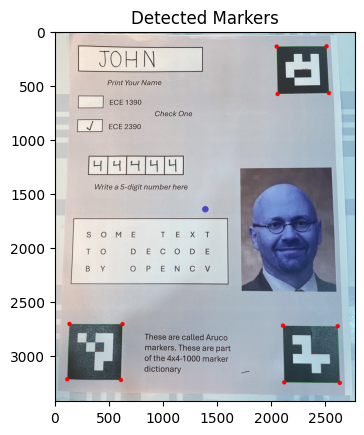

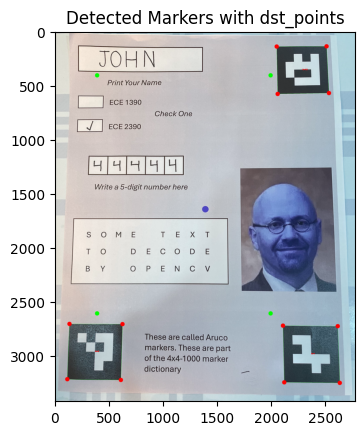

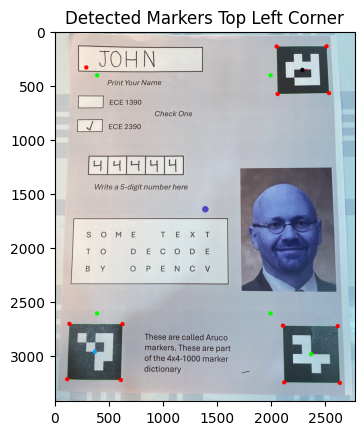

[[2362.25, 2986.5], [368.75, 2963.75], [2281.75, 359.5], [288.25, 336.75]]
[[1988.  409.]
 [1988. 2609.]
 [ 388. 2609.]
 [ 388.  409.]]


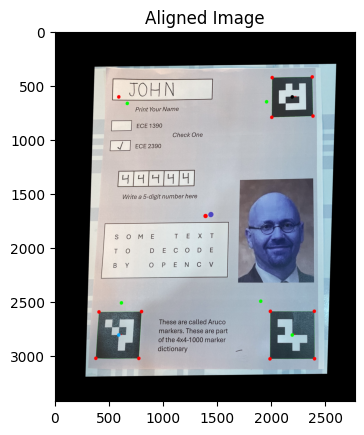

In [50]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import easyocr
import pytesseract
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import argparse
from typing import Tuple, Union
import math
import os
from __future__ import print_function
from multiprocessing.pool import ThreadPool
from numpy.linalg import norm
from common import clock, mosaic




SZ = 20 # size of each digit is SZ x SZ
CLASS_N = 10
DIGITS_FN = "digits.png"

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Step 1: Load the image
image_path = "Color.jpg"  # Replace with the path to your file
real_image = cv2.imread(image_path)

image = real_image.copy()

# Red dot center (in pixels, approximate)
red_dot_x, red_dot_y = image.shape[1] // 2, image.shape[0] // 2

CM_TO_PIXELS = 100
# Step 2: Detect and align using Aruco markers
def align_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Load the Aruco dictionary and detect markers
    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
    parameters = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)
    corners, ids, rejected = detector.detectMarkers(gray)
    
    print(ids)
    
    cv2.aruco.drawDetectedMarkers(image, corners, ids)
    # Draw circles on all detected corners
    if corners:
        for marker_corners in corners:
            for corner in marker_corners[0]:  # marker_corners[0] gives the 4 corners of the marker
                x, y = int(corner[0]), int(corner[1])  # Convert to integers
                image = cv2.circle(image, (x, y), 20, (255, 0, 0), -1)  # Draw a filled circle
    
    plt.imshow(image)
    plt.title("Detected Markers")
    plt.show()
    
    # Define the three known points
    lower_left = np.array([6 * CM_TO_PIXELS + image.shape[1] // 2, -13 * CM_TO_PIXELS + image.shape[0] // 2], dtype=np.float32)
    upper_right = np.array([-10 * CM_TO_PIXELS + image.shape[1] // 2, 9 * CM_TO_PIXELS + image.shape[0] // 2], dtype=np.float32)
    lower_right = np.array([6 * CM_TO_PIXELS + image.shape[1] // 2, 9 * CM_TO_PIXELS + image.shape[0] // 2], dtype=np.float32)
    # Calculate the upper-left point (UL)
    upper_left = upper_right - (lower_right - lower_left)

    # Add the upper-left point to dst_points array
    dst_points = np.array([
        lower_left, 
        lower_right,
        upper_right,   
        upper_left 
    ], dtype=np.float32)
    

    # Draw shifted destination points
    for point in dst_points:
        center = (int(point[0]), int(point[1]))  # Convert point to tuple for center
        cv2.circle(image, center, 20, color=(0, 255, 0), thickness=-1)  # Draw green circles
        
    plt.imshow(image)
    plt.title("Detected Markers with dst_points")
    plt.show()

    # Extract the top-left corners of the detected markers
    src_points = []
    for marker_id in ids.flatten():  # Update based on the IDs of the ArUco markers used
        idx = np.where(ids.flatten() == marker_id)[0]
        if len(idx) > 0:
            marker_corners = corners[idx[0]][0]  # 4 corners of the marker
            # Calculate the center as the average of the 4 corners
            center_x = np.mean(marker_corners[:, 0])
            center_y = np.mean(marker_corners[:, 1])
            src_points.append([center_x, center_y])
            
            colors = [(0, 255, 0), (0, 165, 255), (0, 0, 0)]  # BGR color format
            color = colors[idx[0] % len(colors)]  # Choose color based on the index of the marker
            cv2.circle(image, (int(center_x), int(center_y)), 20, color, -1)  # Draw center circle
            
    if len(src_points) == 3:
        # Extract the known points: lower-left, lower-right, upper-right
        lower_left = np.array(src_points[1])
        lower_right = np.array(src_points[0])
        upper_right = np.array(src_points[2])
        
        # Calculate the upper-left point using vector arithmetic
        upper_left = upper_right - (lower_right - lower_left)
        src_points.append(upper_left.tolist())  # Add the calculated point to src_points
        
        # Visualize the calculated upper-left corner
        cv2.circle(image, (int(upper_left[0]), int(upper_left[1])), 20, (255, 0, 0), -1)  # Draw red circle

            
    plt.imshow(image)
    plt.title("Detected Markers Top Left Corner")
    plt.show()
    
    print(src_points)
    print(dst_points)

    # Convert src_points to a NumPy array
    src_points = np.array(src_points, dtype=np.float32)
    src_points = src_points[[2,0,1,3]]
    height, width = image.shape[:2]

    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    aligned_image = cv2.warpPerspective(image, matrix, (width, height))
        # Calculate the center of the dst_points after transformation
    dst_center = np.mean(dst_points, axis=0)
    aligned_center_x, aligned_center_y = int(dst_center[0]), int(dst_center[1])

    # Shift the aligned image to make dst_center the image center
    shift_x = width // 2 - aligned_center_x
    shift_y = height // 2 - aligned_center_y
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    centered_image = cv2.warpAffine(aligned_image, translation_matrix, (width, height))
    
    return centered_image
        

aligned_image = align_image(image)
cv2.circle(aligned_image, (aligned_image.shape[1]//2, aligned_image.shape[0]//2), 20, (255, 0, 0), -1)
plt.imshow(aligned_image)
plt.title("Aligned Image")
plt.show()

# Questoin 4

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Detected Text: JOHN


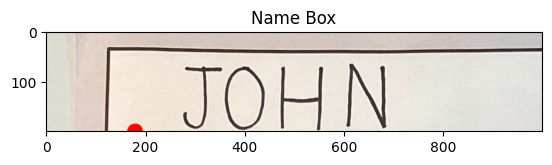

In [51]:

def cm_to_pixel_coords(x_cm, y_cm, center_x, center_y):
    return int(center_x + x_cm * CM_TO_PIXELS), int(center_y + y_cm * CM_TO_PIXELS)

# Define regions
image_center = (image.shape[1] // 2, image.shape[0] // 2)  # Center of the image
regions = {
    "text_box": cm_to_pixel_coords(-9.8, -13, *image_center) + (2 * CM_TO_PIXELS, 10 * CM_TO_PIXELS),
    "checkbox_ece1390": cm_to_pixel_coords(-5.6, -12, *image_center) + (1 * CM_TO_PIXELS, 2 * CM_TO_PIXELS),
    "checkbox_ece2390": cm_to_pixel_coords(-3.75, -12, *image_center) + (1 * CM_TO_PIXELS, 2 * CM_TO_PIXELS),
    "five_digits": [cm_to_pixel_coords(-0.75, x, *image_center) + (CM_TO_PIXELS, CM_TO_PIXELS) for x in [-11, -9.5, -8.5, -7, -5.5]],
    "some_text": cm_to_pixel_coords(4.25, -12.5, *image_center) + (4 * CM_TO_PIXELS, 11 * CM_TO_PIXELS),
    "face_pic": cm_to_pixel_coords(0.25, -0.5, *image_center) + (9 * CM_TO_PIXELS, 7 * CM_TO_PIXELS),
}

# 4) Use EasyOCR to read the text box
def read_name_box(image, region):
    x, y, w, h = region
    cropped = image[x:x+w, y:y+h]
    reader = easyocr.Reader(["en"])
    result = reader.readtext(cropped)
    for (bbox, text, confidence) in result:
        print(f"Detected Text: {text}")
    plt.imshow(cropped)
    plt.title("Name Box")
    plt.show()
    
read_name_box(aligned_image, regions["text_box"])

# Question 5

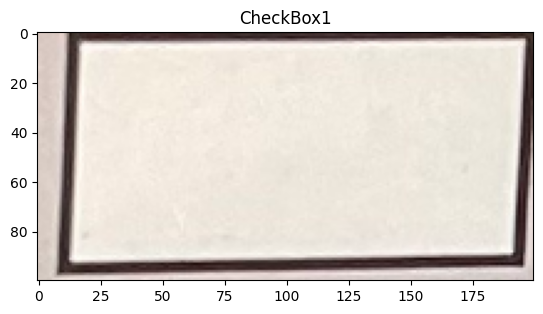

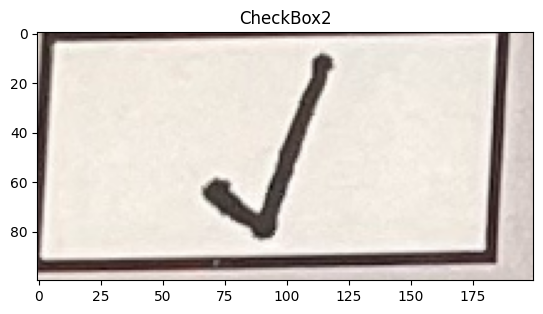

Marked Checkbox: ECE-2390


In [52]:
def check_checkboxes(image, checkbox1_region, checkbox2_region):
    x1, y1, w1, h1 = checkbox1_region
    x2, y2, w2, h2 = checkbox2_region
    checkbox1 = image[x1:x1+w1,y1:y1+h1]
    checkbox2 = image[x2:x2+w2,y2:y2+h2]
    intensity1 = np.mean(checkbox1)
    intensity2 = np.mean(checkbox2)
    marked = "ECE-1390" if intensity1 < intensity2 else "ECE-2390"
    plt.imshow(checkbox1)
    plt.title("CheckBox1")
    plt.show()
    plt.imshow(checkbox2)
    plt.title("CheckBox2")
    plt.show()
    print(f"Marked Checkbox: {marked}")
    
check_checkboxes(aligned_image, regions['checkbox_ece1390'], regions['checkbox_ece2390'])

# Question 6

loading "digits.png" ...
preprocessing...
training SVM...
error: 1.80 %
confusion matrix:
[[45  0  0  0  0  0  0  0  0  0]
 [ 0 57  0  0  0  0  0  0  0  0]
 [ 0  0 59  2  0  0  0  0  0  0]
 [ 0  0  0 43  0  0  0  1  0  0]
 [ 0  0  0  0 40  0  0  0  0  0]
 [ 0  0  0  1  0 50  0  0  0  0]
 [ 0  0  0  0  1  0 51  0  0  0]
 [ 0  0  1  0  0  0  0 54  0  0]
 [ 0  0  0  0  0  0  0  0 47  0]
 [ 0  1  0  1  0  0  0  0  1 45]]

training KNearest...
error: 3.40 %
confusion matrix:
[[45  0  0  0  0  0  0  0  0  0]
 [ 0 57  0  0  0  0  0  0  0  0]
 [ 0  0 59  1  0  0  0  0  1  0]
 [ 0  0  0 43  0  0  0  1  0  0]
 [ 0  0  0  0 38  0  2  0  0  0]
 [ 0  0  0  2  0 48  0  0  1  0]
 [ 0  1  0  0  0  0 51  0  0  0]
 [ 0  0  1  0  0  0  0 54  0  0]
 [ 0  0  0  0  0  1  0  0 46  0]
 [ 1  1  0  1  1  0  0  0  2 42]]



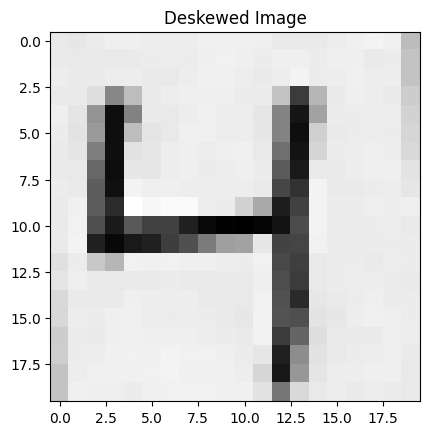

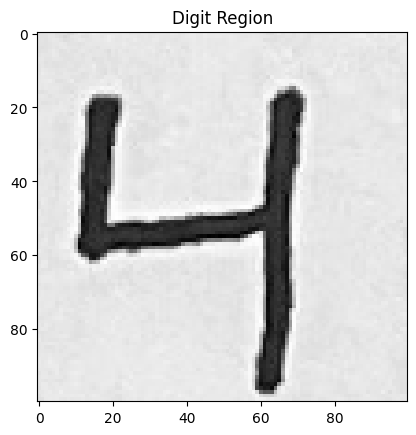

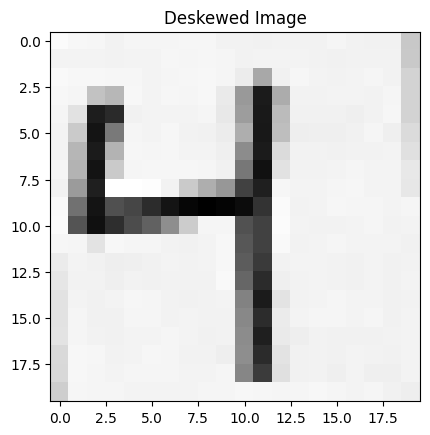

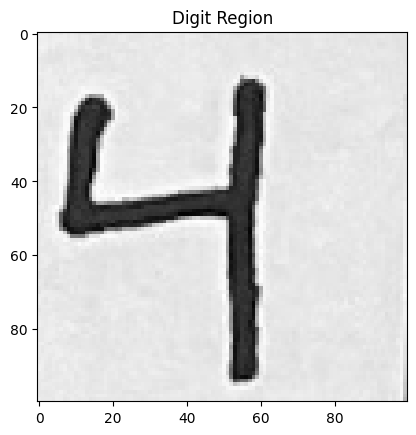

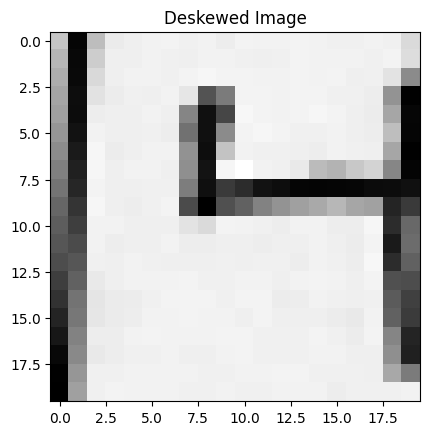

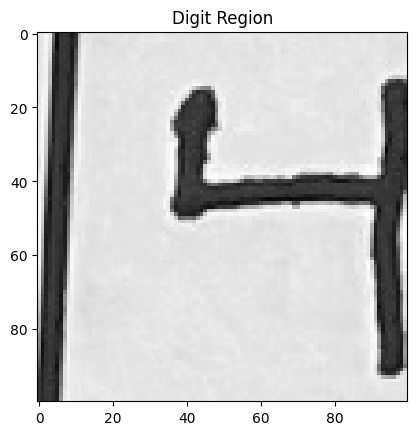

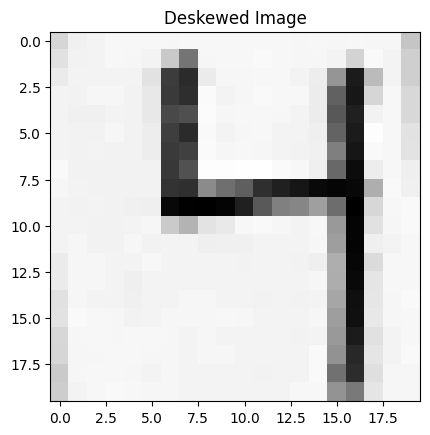

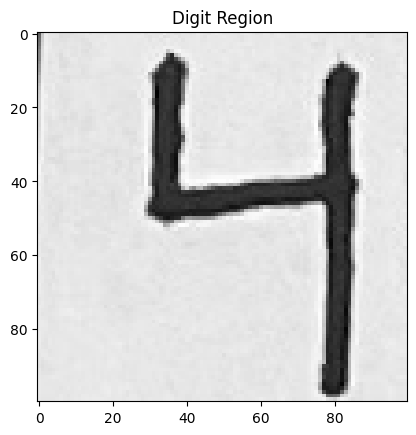

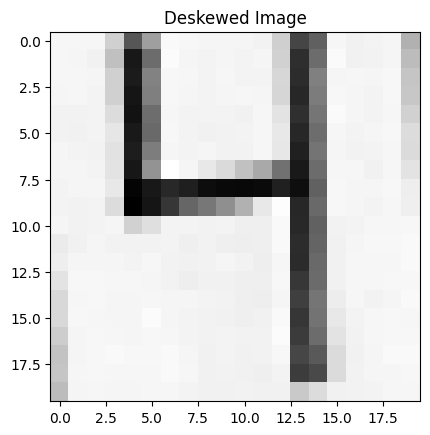

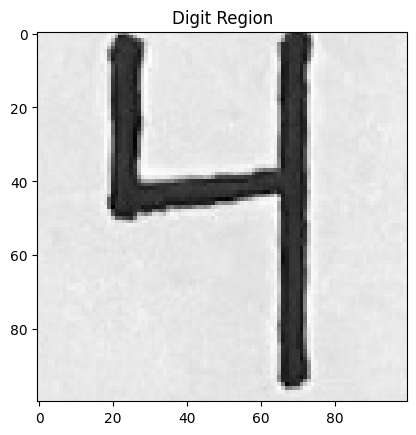

Decoded 5-Digit Number: [4, 4, 8, 9, 4]
Actual Digits: [4, 4, 4, 4, 4]


In [53]:

def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w//sx) for row in np.vsplit(img, h//sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells

def load_digits(fn):
    #fn = cv.samples.findFile(fn)
    print('loading "%s" ...' % fn)
    digits_img = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
    digits = split2d(digits_img, (SZ, SZ))
    labels = np.repeat(np.arange(CLASS_N), len(digits)/CLASS_N)
    return digits, labels

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img


class KNearest(object):
    def __init__(self, k = 3):
        self.k = k
        self.model = cv2.ml.KNearest_create()

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        _retval, results, _neigh_resp, _dists = self.model.findNearest(samples, self.k)
        return results.ravel()

    def load(self, fn):
        self.model = cv2.ml.KNearest_load(fn)

    def save(self, fn):
        self.model.save(fn)

class SVM(object):
    def __init__(self, C = 1, gamma = 0.5):
        self.model = cv2.ml.SVM_create()
        self.model.setGamma(gamma)
        self.model.setC(C)
        self.model.setKernel(cv2.ml.SVM_RBF)
        self.model.setType(cv2.ml.SVM_C_SVC)

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        return self.model.predict(samples)[1].ravel()

    def load(self, fn):
        self.model = cv2.ml.SVM_load(fn)

    def save(self, fn):
        self.model.save(fn)
        

def evaluate_model(model, digits, samples, labels):
    resp = model.predict(samples)
    err = (labels != resp).mean()
    print('error: %.2f %%' % (err*100))

    confusion = np.zeros((10, 10), np.int32)
    for i, j in zip(labels, resp):
        confusion[i, int(j)] += 1
    print('confusion matrix:')
    print(confusion)
    print()

    vis = []
    for img, flag in zip(digits, resp == labels):
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        if not flag:
            img[...,:2] = 0
        vis.append(img)
    return mosaic(25, vis)

def preprocess_simple(digits):
    return np.float32(digits).reshape(-1, SZ*SZ) / 255.0

def preprocess_hog(digits):
    samples = []
    for img in digits:
        gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
        gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
        mag, ang = cv2.cartToPolar(gx, gy)
        bin_n = 16
        bin = np.int32(bin_n*ang/(2*np.pi))
        bin_cells = bin[:10,:10], bin[10:,:10], bin[:10,10:], bin[10:,10:]
        mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
        hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
        hist = np.hstack(hists)

        # transform to Hellinger kernel
        eps = 1e-7
        hist /= hist.sum() + eps
        hist = np.sqrt(hist)
        hist /= norm(hist) + eps

        samples.append(hist)
    return np.float32(samples)

def predict_digit(model, img):

    img = cv2.resize(img, (SZ, SZ), interpolation=cv2.INTER_AREA)
    img = deskew(img)
    plt.imshow(img, cmap='gray')
    plt.title("Deskewed Image")
    plt.show()
    sample = preprocess_hog([img])
    response = model.predict(sample)
    return int(response[0])


def decode_five_digits(image, digit_regions):

    digits, labels = load_digits(DIGITS_FN)

    print('preprocessing...')
    # shuffle digits
    rand = np.random.RandomState(321)
    shuffle = rand.permutation(len(digits))
    digits, labels = digits[shuffle], labels[shuffle]

    digits2 = list(map(deskew, digits))
    samples = preprocess_hog(digits2)

    train_n = int(0.9*len(samples))
    digits_train, digits_test = np.split(digits2, [train_n])
    samples_train, samples_test = np.split(samples, [train_n])
    labels_train, labels_test = np.split(labels, [train_n])


    print('training SVM...')
    svm_model = SVM(C=2.67, gamma=5.383)
    svm_model.train(samples_train, labels_train)
    vis = evaluate_model(svm_model, digits_test, samples_test, labels_test)
    svm_model.save('digits_svm.dat')
    
    print('training KNearest...')
    kn_model = KNearest(k=4)
    kn_model.train(samples_train, labels_train)
    vis = evaluate_model(kn_model, digits_test, samples_test, labels_test)
    
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    digits = []
    for region in digit_regions:
        x, y, w, h = region
        cropped = gray[x:x+w,y:y+h]
        digit = predict_digit(kn_model, cropped)
        digits.append(digit)
        plt.imshow(cropped, cmap='gray')
        plt.title("Digit Region")
        plt.show()
    print(f"Decoded 5-Digit Number: {digits}")
    print(f"Actual Digits: [4, 4, 4, 4, 4]")
    
decode_five_digits(aligned_image, regions['five_digits'])

# Question 7

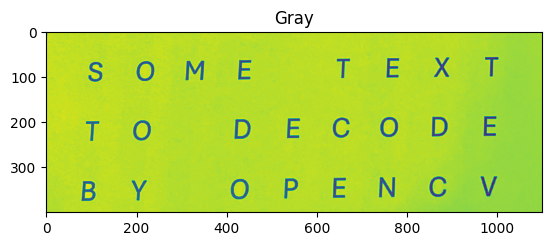

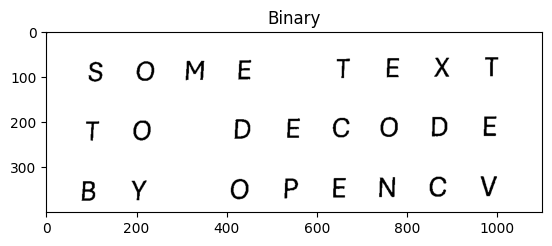

Confidence: 85
Text: |

Confidence: 90
Text: S

Confidence: 88
Text: OME

Confidence: 87
Text: T

Confidence: 89
Text: E

Confidence: 89
Text: X

Confidence: 86
Text: T

Confidence: 84
Text: T

Confidence: 86
Text: O

Confidence: 90
Text: D

Confidence: 29
Text: ECO

Confidence: 52
Text: DE

Confidence: 74
Text: B

Confidence: 74
Text: Y

Confidence: 89
Text: O

Confidence: 91
Text: P

Confidence: 92
Text: EN

Confidence: 85
Text: C

Confidence: 84
Text: V



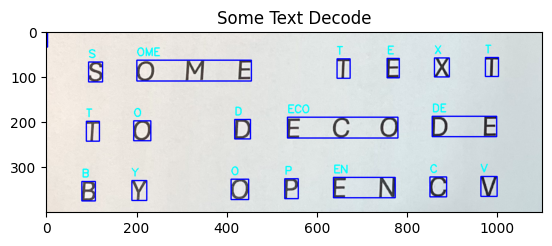

In [ ]:
   
def image_to_words(image, min_conf=0):
   
    # We load the input image and then convert 
    # it to RGB from BGR. We then use Tesseract 
    # to localize each area of text in the input 
    # image 
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='gray')
    plt.title("Gray")
    plt.show()
    _, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    plt.imshow(binary_image, cmap='gray')
    plt.title("Binary")
    plt.show()
    config = "--psm 6"
    results = pytesseract.image_to_data(binary_image, output_type=pytesseract.Output.DICT, config=config) 
    
    
    # Then loop over each of the individual text 
    # localizations 
    for i in range(len(results["text"])):
        # Extract bounding box coordinates and OCR data
        x, y, w, h = results["left"][i], results["top"][i], results["width"][i], results["height"][i]
        text = results["text"][i]
        conf = int(results["conf"][i])

        # Filter out detections with low confidence
        if conf > min_conf:
            # Print the confidence and text
            print(f"Confidence: {conf}")
            print(f"Text: {text.strip()}")
            print("")

            # Draw the bounding box and text on the image
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
            cv2.putText(image, text.strip(), (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
            
    plt.imshow(image)
    plt.title("Some Text Decode")
    plt.show()
    
def decode_some_text(image, region):
    x, y, w, h = region
    cropped = image[x:x+w, y:y+h]
    image_to_words(cropped)
    
decode_some_text(aligned_image, regions["some_text"])

# Question 8(2390)

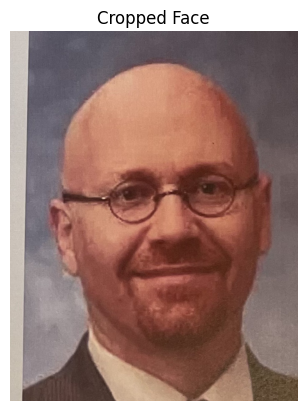

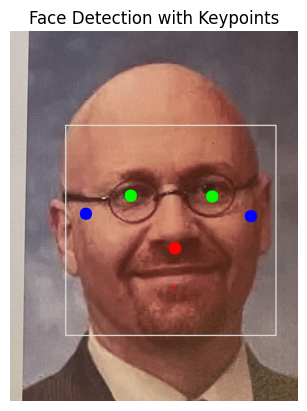

In [55]:
#I refrenced this code online at this link here:
def face_features(image, region):
    # Extract the region of interest
    x, y, w, h = region
    cropped = image[x:x+w, y:y+h]  # Correct slicing order for images (y, x, h, w)
    
    mp_face_detection = mp.solutions.face_detection
    mp_drawing = mp.solutions.drawing_utils

    # Define a function to draw circles on specific keypoints
    def draw_circle(image, key_point, color, radius=15):
        cv2.circle(image, (int(key_point.x * image.shape[1]), int(key_point.y * image.shape[0])), 
                   radius, color, thickness=-1)

    # For static images:
    with mp_face_detection.FaceDetection(
            model_selection=1, min_detection_confidence=0.5) as face_detection:
        
        # Display the cropped region
        plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        plt.title("Cropped Face")
        plt.axis('off')
        plt.show()
        
        # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
        results = face_detection.process(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        

        # If detections are found
        if results.detections:
            annotated_image = cropped.copy()

            # Loop through detections
            for detection in results.detections:
                # Get and draw circles on specific keypoints
                mp_drawing.draw_detection(annotated_image, detection)
                nose_tip = mp_face_detection.get_key_point(
                    detection, mp_face_detection.FaceKeyPoint.NOSE_TIP)
                left_eye = mp_face_detection.get_key_point(
                    detection, mp_face_detection.FaceKeyPoint.LEFT_EYE)
                right_eye = mp_face_detection.get_key_point(
                    detection, mp_face_detection.FaceKeyPoint.RIGHT_EYE)
                left_ear = mp_face_detection.get_key_point(
                    detection, mp_face_detection.FaceKeyPoint.LEFT_EAR_TRAGION)
                right_ear = mp_face_detection.get_key_point(
                    detection, mp_face_detection.FaceKeyPoint.RIGHT_EAR_TRAGION)

                # Draw keypoints on the annotated image
                draw_circle(annotated_image, nose_tip, (0, 0, 255))  # Red for nose tip
                draw_circle(annotated_image, left_eye, (0, 255, 0))  # Green for left eye
                draw_circle(annotated_image, right_eye, (0, 255, 0))  # Green for right eye
                draw_circle(annotated_image, left_ear, (255, 0, 0))  # Blue for left ear
                draw_circle(annotated_image, right_ear, (255, 0, 0))  # Blue for right ear

            # Display the annotated image
            plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
            plt.title("Face Detection with Keypoints")
            plt.axis('off')
            plt.show()

        else:
            print("No detections found.")
        
face_features(aligned_image, regions["face_pic"])